# Transfer Learning

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

In [3]:
# interactive mode
plt.ion()

## 1. Data

* augmentation and normalization for training
* normalization for validation

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
data_dir = './data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=16) for x in ['train', 'val']}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}; dataset_sizes

{'train': 244, 'val': 153}

In [10]:
class_names = image_datasets['train'].classes; class_names

['ants', 'bees']

In [12]:
use_gpu = torch.cuda.is_available(); use_gpu

True

### image examples

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

In [14]:
inputs, classes = next(iter(dataloaders['train']))

Make a grid from batch

In [15]:
out = torchvision.utils.make_grid(inputs)

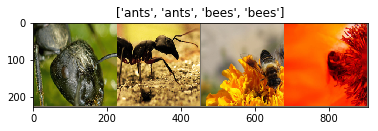

In [16]:
imshow(out, title=[class_names[x] for x in classes])

## 2. Train model

In [29]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=25):
    since = time.time()
    
    best_model_weights = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs-1}')
        print('-' * 10)
        
        # each epoch has a training and validation fase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) # set model to training mode
            else:
                model.train(False) # set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
                
                # zero parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # backward + optimize if training
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # stats
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = model.state_dict()
            
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_weights)
    return model
                
                

Visualize model predictions

In [35]:
def visualize_model(model, n_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(n_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == n_images:
                return

Finetune the convnet

In [31]:
model_ft = models.resnet18(pretrained=True)
n_filters = model_ft.fc.in_features
model_ft.fc = nn.Linear(n_filters, 2)

model_ft.cuda()

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# decay lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate 

In [33]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, n_epochs=25)

Epoch 0/24
----------
train Loss: 0.1224 Acc: 0.7582
val Loss: 0.0609 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.1298 Acc: 0.7869
val Loss: 0.0608 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.1257 Acc: 0.7746
val Loss: 0.1106 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.1166 Acc: 0.8361
val Loss: 0.0686 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.1475 Acc: 0.7951
val Loss: 0.0649 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.1556 Acc: 0.7746
val Loss: 0.0719 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.1171 Acc: 0.8238
val Loss: 0.0518 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.0647 Acc: 0.8730
val Loss: 0.0444 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.0716 Acc: 0.8852
val Loss: 0.0443 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.0858 Acc: 0.8566
val Loss: 0.0485 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.0819 Acc: 0.8648
val Loss: 0.0482 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0822 Acc: 0.8689
val Loss: 0.0416 Acc: 0.9346

Ep

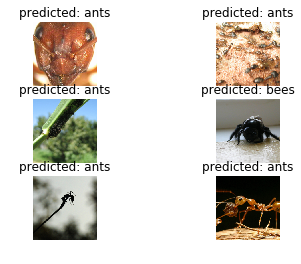

In [36]:
visualize_model(model_ft)